<a href="https://colab.research.google.com/github/dkaravaev/wavelet-ccnn/blob/master/AlternativeModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import metrics
from tensorflow.keras import activations

from sklearn.model_selection import train_test_split

from google.colab import drive

drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/python/'
sys.path.append(path)

from datasets.chaos   import *
from datasets.chirp   import *
from datasets.predict import *
from datasets.utils   import *

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
N = 1024

def ConvLSTM(kernel_size, filters):
  model = models.Sequential()
  model.add(layers.Conv1D(filters,
                  kernel_size,
                  padding='causal',
                  strides=1,
                  kernel_regularizer='l2',
                  input_shape=(N, 2)))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU())
  model.add(layers.Conv1D(filters,
                  kernel_size,
                  padding='causal',
                  strides=1,
                  kernel_regularizer='l2'))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU())
  model.add(layers.LSTM(2, return_sequences = True, kernel_regularizer='l2'))

  model.compile(loss='mse', optimizer='adam', metrics=['mse'])
  
  return model

def FullyConv(kernel_size, filters, depth):
  model = models.Sequential()
  model.add(layers.Conv1D(filters,
                  kernel_size,
                  padding='causal',
                  strides=1,
                  kernel_regularizer='l2',
                  input_shape=(N, 2)))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU())
  
  for i in range(depth - 1):
    model.add(layers.Conv1D(filters,
                    kernel_size,
                    padding='causal',
                    strides=1,
                    kernel_regularizer='l2',
                    dilation_rate=2,
                    input_shape=(N, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU())
    
  model.add(layers.Conv1D(1, 1, kernel_regularizer='l2'))

  model.compile(loss='mse', optimizer='adam', metrics=['mse'])
  
  return model

kernel_size = 4
filters = 32

batch_size = 100
epochs = 15

In [0]:
dataset = IkedaMap(40000 + N, N, z0=0.5 + 0 * 1j, A=1, 
                   B=0.9, K=-6, C=0.4, SNRdB=-1)
X, y = dataset.generate()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.08, shuffle=False)

In [5]:
conv_lstm = ConvLSTM(kernel_size, filters)
conv_lstm_history = conv_lstm.fit(X_train, y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_data=(X_test, y_test))

Epoch 1/15
378/378 [==============================] - 48s 128ms/step - loss: 0.3283 - mse: 0.1454 - val_loss: 0.3407 - val_mse: 0.2980
Epoch 2/15
378/378 [==============================] - 43s 114ms/step - loss: 0.1163 - mse: 0.0892 - val_loss: 0.1301 - val_mse: 0.1103
Epoch 3/15
378/378 [==============================] - 43s 114ms/step - loss: 0.1041 - mse: 0.0868 - val_loss: 0.1110 - val_mse: 0.0955
Epoch 4/15
378/378 [==============================] - 43s 114ms/step - loss: 0.1000 - mse: 0.0856 - val_loss: 0.1066 - val_mse: 0.0932
Epoch 5/15
378/378 [==============================] - 43s 113ms/step - loss: 0.0974 - mse: 0.0848 - val_loss: 0.1041 - val_mse: 0.0922
Epoch 6/15
378/378 [==============================] - 42s 112ms/step - loss: 0.0954 - mse: 0.0842 - val_loss: 0.1028 - val_mse: 0.0921
Epoch 7/15
378/378 [==============================] - 42s 112ms/step - loss: 0.0938 - mse: 0.0837 - val_loss: 0.1013 - val_mse: 0.0917
Epoch 8/15
378/378 [==============================] - 4

In [6]:
full_conv = FullyConv(kernel_size, filters, depth=8)
full_conv_history = full_conv.fit(X_train, y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_data=(X_test, y_test))

Epoch 1/15
378/378 [==============================] - 31s 81ms/step - loss: 1.3916 - mse: 0.5525 - val_loss: 0.8162 - val_mse: 0.6968
Epoch 2/15
378/378 [==============================] - 30s 79ms/step - loss: 0.5217 - mse: 0.4783 - val_loss: 0.6282 - val_mse: 0.6144
Epoch 3/15
378/378 [==============================] - 30s 80ms/step - loss: 0.4854 - mse: 0.4769 - val_loss: 0.5709 - val_mse: 0.5655
Epoch 4/15
378/378 [==============================] - 30s 79ms/step - loss: 0.4814 - mse: 0.4766 - val_loss: 0.5544 - val_mse: 0.5510
Epoch 5/15
378/378 [==============================] - 30s 80ms/step - loss: 0.4784 - mse: 0.4759 - val_loss: 0.5237 - val_mse: 0.5217
Epoch 6/15
378/378 [==============================] - 30s 80ms/step - loss: 0.4771 - mse: 0.4755 - val_loss: 0.5026 - val_mse: 0.5011
Epoch 7/15
378/378 [==============================] - 30s 80ms/step - loss: 0.4768 - mse: 0.4755 - val_loss: 0.5000 - val_mse: 0.4987
Epoch 8/15
378/378 [==============================] - 30s 80ms

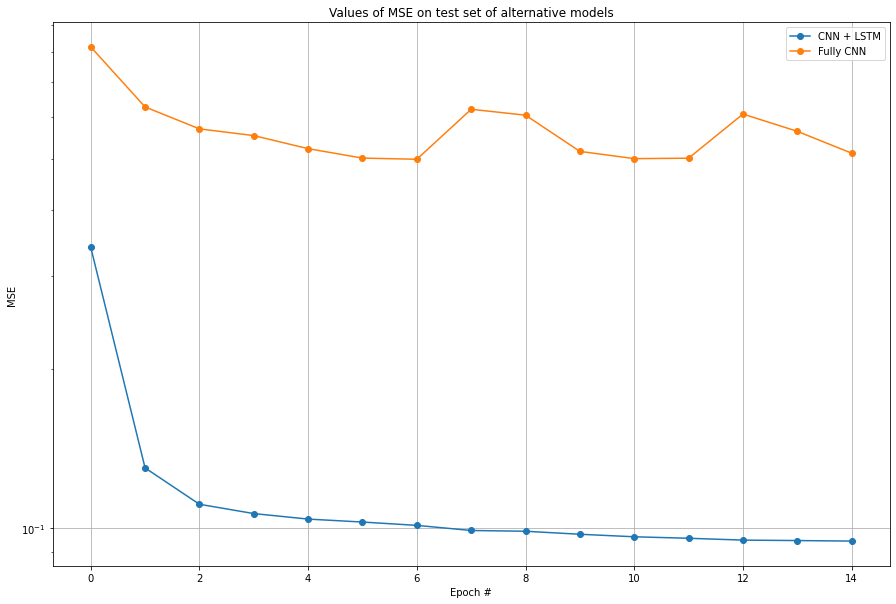

In [7]:
plt.figure(figsize=(15, 10))
plt.plot(conv_lstm_history.history['val_loss'], marker='o', label='CNN + LSTM')
plt.plot(full_conv_history.history['val_loss'], marker='o', label='Fully CNN')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.ylabel('MSE')
plt.xlabel('Epoch #')
plt.title('Values of MSE on test set of alternative models')
plt.show()

In [8]:
conv_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1024, 32)          288       
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 32)          128       
_________________________________________________________________
elu (ELU)                    (None, 1024, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1024, 32)          4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 32)          128       
_________________________________________________________________
elu_1 (ELU)                  (None, 1024, 32)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1024, 2)           2

In [9]:
full_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1024, 32)          288       
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024, 32)          128       
_________________________________________________________________
elu_2 (ELU)                  (None, 1024, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 32)          4128      
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024, 32)          128       
_________________________________________________________________
elu_3 (ELU)                  (None, 1024, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1024, 32)         